# Tempo de experiência vs Salário (India)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np

dados = pd.read_csv("Salary_Data.csv", sep=",")

In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


In [4]:
dados.describe()

,Age,Years of Experience,Salary
count,6702.000000,6701.000000,6699.000000
mean,33.620859,8.094687,115326.964771
std,7.614633,6.059003,52786.183911
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


In [5]:
# Verificando valores nulos
dados.isna().sum()

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64

In [6]:
# Dropando os nulos da coluna "Years of Experience" e "Salary" porque iremos usá-las na regressão
dados = dados.dropna(subset=['Years of Experience', 'Salary'])

In [7]:
dados.isna().sum()

Age                    0
Gender                 0
Education Level        1
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64

#### Boxplot geral

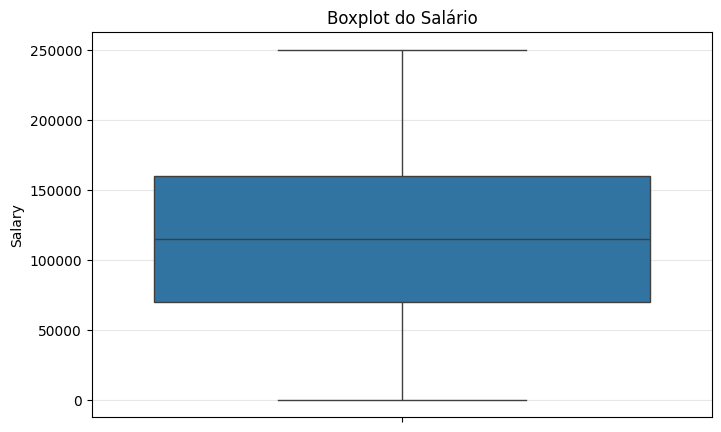

In [8]:
plt.figure(figsize=(8, 5))
sns.boxplot(y=dados['Salary'])
plt.title('Boxplot do Salário')
plt.ylabel('Salary')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

Olhando o boxplot geral, não temos outliers (os "bigodes" vão de 0 a 250k). Mas aqui poderiamos tirar uma conclusão enganosa: parece que está tudo normal. Isso acontece porque a variância global é tão grande que "esconde" os problemas locais. Vamos ver o boxplot por ano de experiência abaixo:

#### Boxplot por ano de experiência

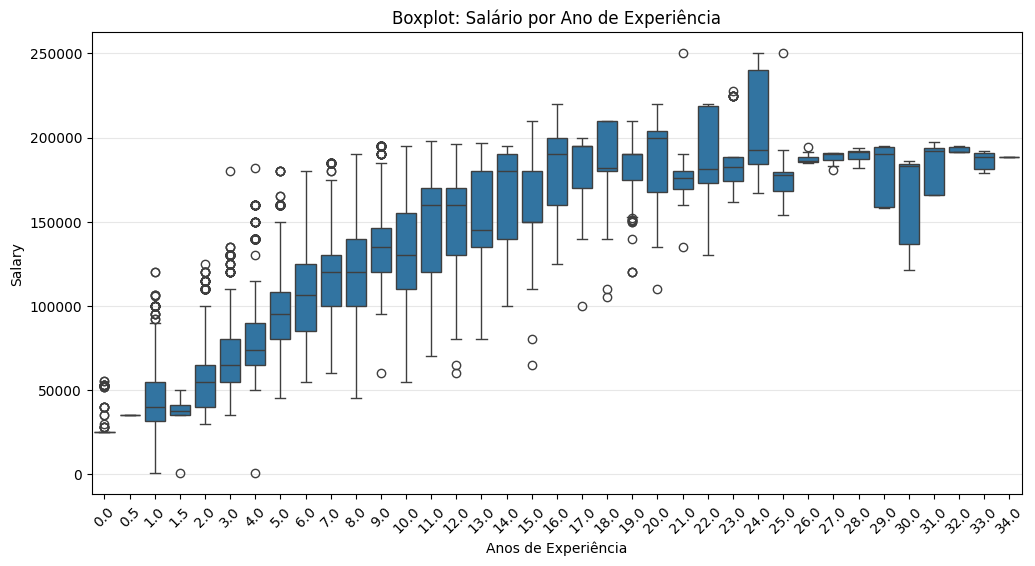

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Years of Experience', y='Salary', data=dados, showfliers=True)
plt.title('Boxplot: Salário por Ano de Experiência')
plt.xlabel('Anos de Experiência')
plt.ylabel('Salary')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.show()

Vendo o boxplot por ano de experiência, vemos grandes outliers. Nos anos 1, 1.5, 3 e 4 temos bolinhas (outliers) socadas no zero (ou muito perto dele), enquanto a caixa (a maioria das pessoas) nesses anos ganha entre 40k e 60k, tem gente ganhando 0. Possivelmente são dados cadastrados de forma errada ou estagiários não remunerados que não deveriam estar em nossa análise.

In [10]:
# Limpando os outliers vistos
dados = dados[dados['Salary'] > 10000]

## Avaliando a distribuição dos dados

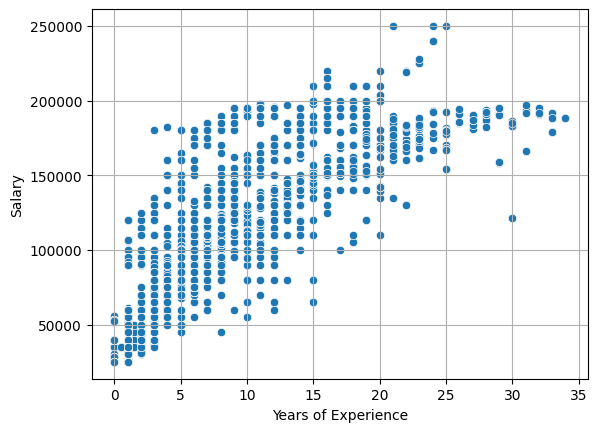

In [11]:
# Observando como está a dispersão dos dados
sns.scatterplot(x="Years of Experience", y="Salary", data=dados)
plt.grid(True)

À primeira vista, o gráfico de dispersão sugere uma relação linear positiva entre anos de experiência e salário. No entanto, assumir que um modelo linear simples basta seria precipitado: uma análise estatística mais rigorosa revelará que a dispersão desigual dos dados (heterocedasticidade) viola pressupostos fundamentais, indicando que a relação real é mais complexa do que uma simples reta sugere.

# Avaliando os pressupostos da regressão



Rodando o modelo

In [ ]:
# MODELO DE REGRESSÃO
modelo = smf.ols(formula="Salary ~ Q('Years of Experience')", data=dados).fit()

In [13]:
# Configuração do modelo para ajuste dos residuos
# fitted_values, residuals

fitted_values = modelo.fittedvalues
residuals = modelo.resid

Visualizando a reta da regressão:

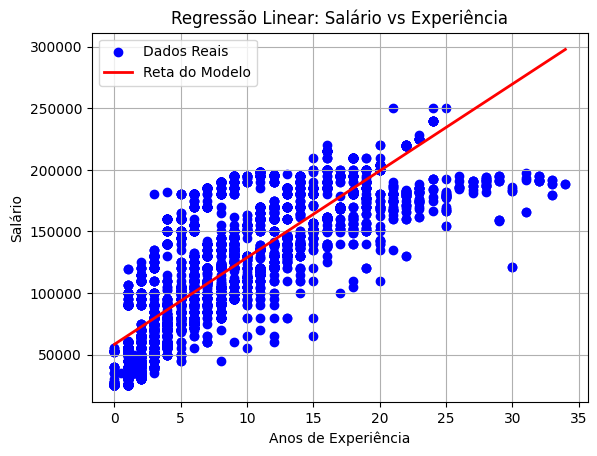

In [15]:
# Plotando o scatter
plt.scatter(dados['Years of Experience'], dados['Salary'], color='blue', label='Dados Reais')

# Plotando a reta
X_plot = dados['Years of Experience'].sort_values()
Y_pred = modelo.predict(X_plot) # Pedindo pro modelo prever o Y para esses X ordenados

plt.plot(X_plot, Y_pred, color='red', linewidth=2, label='Reta do Modelo')

# Decorações do gráfico
plt.xlabel("Anos de Experiência")
plt.ylabel("Salário")
plt.title("Regressão Linear: Salário vs Experiência")
plt.legend()
plt.grid(True)
plt.show()

Podemos notar que a reta do modelo erra bastante mais à direita do gráfico (pelo menos 100.000 rupias). Parece que o salário estabilizou, mas a reta segue subindo. Vamos analisar a normalidade dos dados com o gráfico Q-Q

## Q-Q normal

Avaliando a normalidade (os dados seguem uma distribuição normal?)

Text(0.5, 1.0, 'Normal Q-Q')

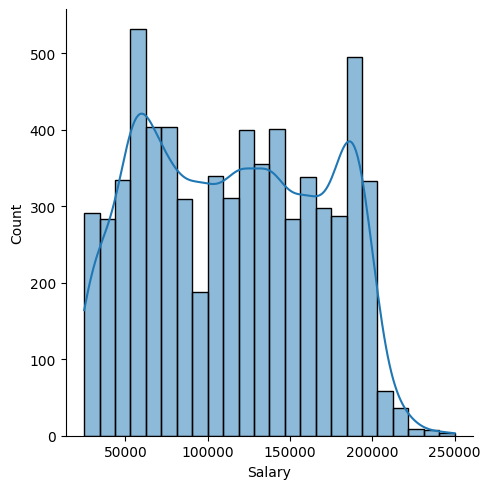

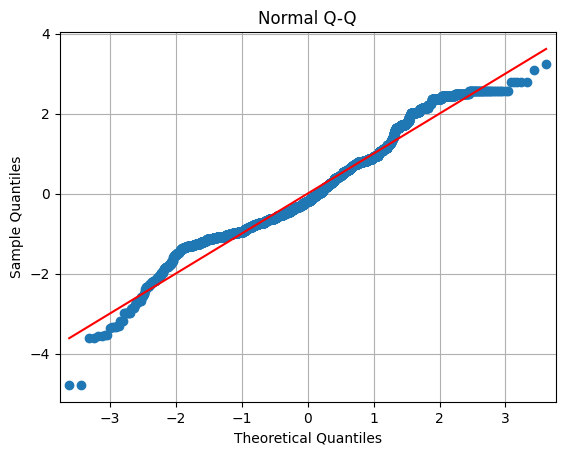

In [17]:
# Calcula os residuos normalizados a partir do modelo
norm_residuals = modelo.get_influence().resid_studentized_internal
sns.displot(dados, x="Salary", kde=True)

# Plota o gráfico de avaliação da normalidade
QQ = qqplot(norm_residuals, line='s')
plt.grid(True)
plt.title("Normal Q-Q")

Um modelo de regressão linear assume que os erros (resíduos) se comportam de forma "normal", ou seja, a maioria dos erros é pequeno, e erros muito grandes (positivos ou negativos) são raros e simétricos (curva de sino). Porque é exatamente isso o que você espera ao usar uma regressão linear: que seus dados sejam lineares e conforme seu X "anda", as previsões estejam mais ou menos certas, ou seja, ao redor da reta do modelo (esperamos que os erros sigam uma distribuição normal, ou seja, que a média do erro seja próxima à 0)

**Analisando o QQ Plot:**

As bolinhas deveriam estar "abraçadas" na linha vermelha do começo ao fim. Mas as bolinhas formam um "S". Elas fogem da linha nas pontas (embaixo à esquerda e em cima à direita) e fazem uma barriga no meio.

Isso é um clássico sinal de caudas leves (light tails) ou uma distribuição bimodal. Seus erros não são normais. O modelo está errando de forma sistemática nas extremidades, não aleatória.

## Resíduos vs Valores (Residuals vs Fitted)

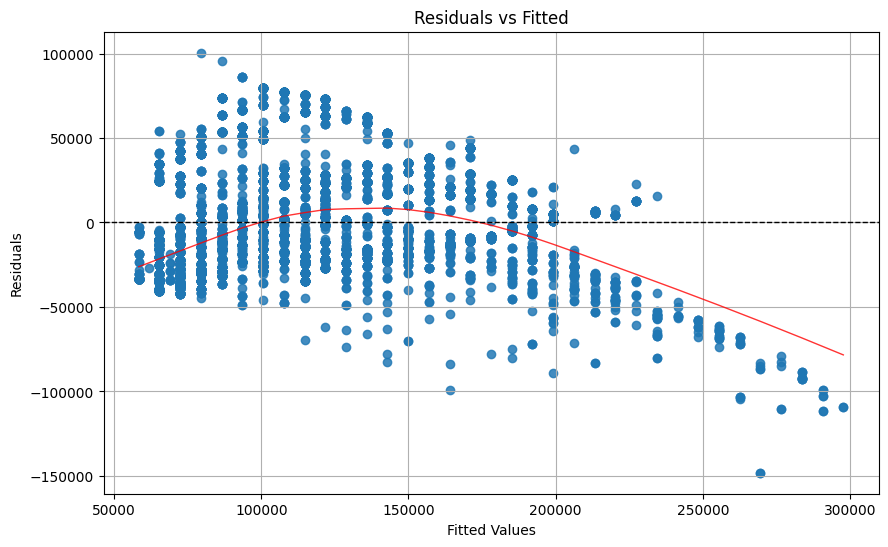

In [33]:
plt.figure(figsize=(10, 6))

# Plota o scatterplot (as bolinhas)
sns.scatterplot(x=fitted_values, y=residuals, alpha=0.2)

# Linha de tendência (LOWESS) para identificar não-linearidade (a linha vermelha)
sns.regplot(x=fitted_values, y=residuals, ci=False, lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

# Linha de referência no zero (crucial neste gráfico para representar onde está o erro zero)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Configura os títulos do gráfico
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(True)


### Leitura do gráfico Residuals vs Fitted

Temos um formato de "U" invertido (parábola). O modelo está sistematicamente errando o padrão dos dados. Para salários baixos e altos, ele superestima o valor (resíduos negativos). Para salários médios, ele subestima o valor (resíduos positivos). Com isso, temos um forte indício de que a relação funcional entre as variáveis não é linear.

Provavelmente um modelo polinomial (ex:  Salary ~ Experience + Experience^2 ) ou logarítmico se ajustaria melhor, fazendo a linha vermelha ficar mais reta passando por cima do zero.

## Bônus: Escala-Localização 
Também é chamado de gráfico de dispersão-localização (Spread-Location)

É um gráfico um pouco mais especializado que o de "Residuals vs Fitted"

Enquanto o *Residuals vs Fitted* analisa linearidade e variância juntas, o **Scale-Location** serve exclusivamente como uma "lupa" para detectar **Heterocedasticidade** (variância desigual).

**O Truque:** Ele usa a raiz quadrada dos resíduos padronizados ($\sqrt{|Standardized Residuals|}$), eliminando o sinal negativo. Isso facilita visualizar se a dispersão dos erros está crescendo.

**Como Interpretar:**
*   **Linha Horizontal:** Ideal (Homocedasticidade). O erro é constante.
*   **Linha Subindo:** Problema (Heterocedasticidade). O erro aumenta junto com a previsão (formato de funil).

**Quando usar:** Quando o gráfico de resíduos padrão deixar dúvida se existe ou não heterocedasticidade.

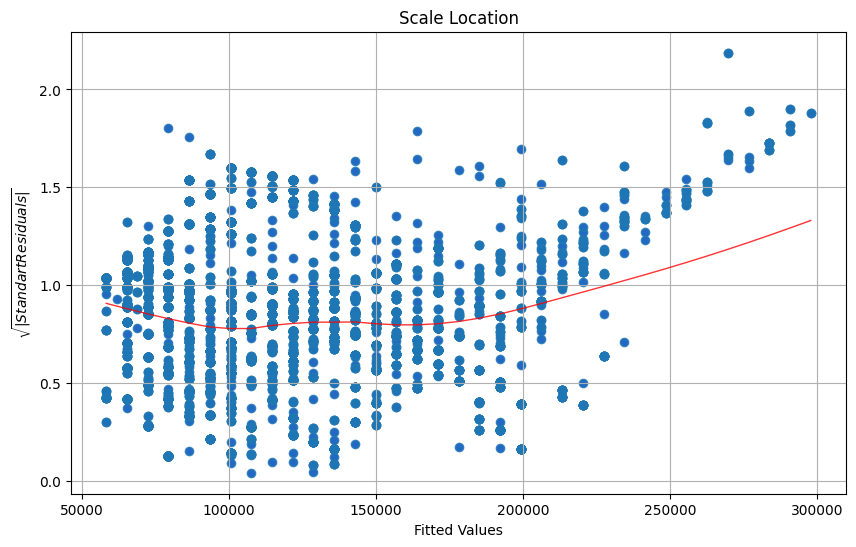

In [38]:
# É preciso calcular a raiz quadrada da normalização dos residuos 
# OBS: a raíz quadrada serve para suavizar outliers, dando maior foco na visualização da tendência da linha
norm_residuals_ab_sqrt = np.sqrt(np.abs(norm_residuals))

plt.figure(figsize=(10, 6))

sns.scatterplot(x=fitted_values, y=norm_residuals_ab_sqrt, color='blue', alpha=0.8)
sns.regplot(x=fitted_values, y=norm_residuals_ab_sqrt, ci=False, lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

# Configurando titulos nos gráficos
plt.title("Scale Location")
plt.xlabel("Fitted Values")
plt.ylabel("$\sqrt {|Standart Residuals|}$")
plt.grid(True)

### Leitura do gráfico Scale-Location

Neste caso, usamos o gráfico de *Scale-Location* para verificar se o modelo é tão preciso prevendo salários baixos quanto salários altos. O gráfico mostra um problema clássico de Heterocedasticidade Crescente, observe que linha vermelha vai crescendo à direita, ou seja, a magnitude média dos erros está aumentando conforme o salário previsto aumenta, também podemos ver que os pontos azuis na esquerda do gráfico, estão mais esprimidos (baixa variância no erro, ou seja, respostas mais precisas) enquanto mais à direita do gráfico os pontos estão espalhados para todo lado, lá no alto. Ou seja, o modelo é melhor para prever salário de pessoas com menos anos de experiência. Isso viola a premissa de que o modelo tem a mesma confiança em todo o intervalo. Você nao pode confiar nas previsões para cargos seniores com a mesma fé que confia nas de juniores.}

# Testando regressão com reta logarítmica

Notamos que o salário parece estabilizar (achatar) mais à direita dos dados (pra sêniores), então vamos experimentar usar o logarítmo na função do modelo para curvarmos a reta da regressão.

In [39]:
# OBS: somamos 1 porque temos dados de "Years of Experience" igual à 0, e log(0) é infinito negativo, então precisamos somar 1.
# Outra formula que poderia ser útil: "np.log(Salary) ~ np.log(Q('Years of Experience') + 1)
modelo_log = smf.ols(formula="Salary ~ np.log(Q('Years of Experience') + 1)", data=dados).fit()

In [40]:
fitted_values_log = modelo_log.fittedvalues
residuals_log = modelo_log.resid

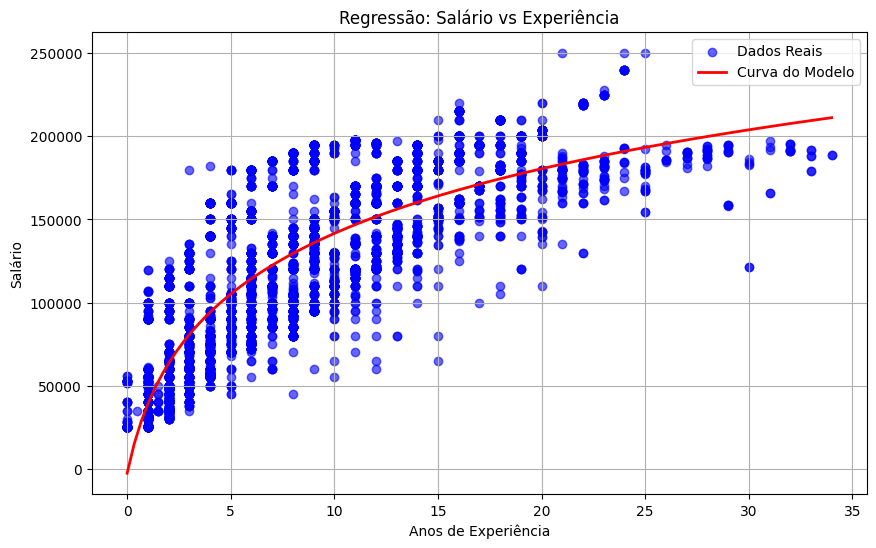

In [43]:
# Criando uma sequência de 0 até o máximo de Years of Experience que temos
x_range = np.linspace(dados['Years of Experience'].min(), dados['Years of Experience'].max(), 100)

df_plot = pd.DataFrame({'Years of Experience': x_range})

# Prevendo o Y com o modelo
y_pred = modelo_log.predict(df_plot)

# Plotando
plt.figure(figsize=(10, 6))
plt.scatter(dados['Years of Experience'], dados['Salary'], color='blue', alpha=0.6, label='Dados Reais')
plt.plot(df_plot['Years of Experience'], y_pred, color='red', linewidth=2, label='Curva do Modelo')

plt.xlabel("Anos de Experiência")
plt.ylabel("Salário")
plt.title("Regressão: Salário vs Experiência")
plt.legend()
plt.grid(True)
plt.show()


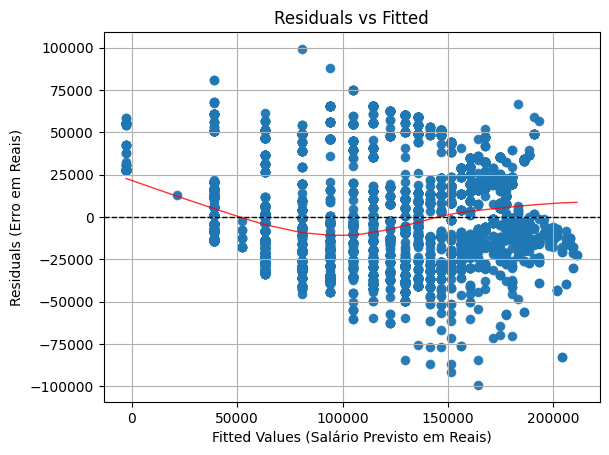

In [ ]:
# PLOTANDO O GRÁFICO RESIDUALS VS FITTED
# Nota: fitted_values_log e residuals_log já estão na escala logarítmica (o correto aqui)
sns.scatterplot(x=fitted_values_log, y=residuals_log, alpha=0.8)

# Linha de tendência (LOWESS)
sns.regplot(x=fitted_values_log, y=residuals_log, ci=False, lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

# Linha de referência no zero
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Configura títulos nos gráficos
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted Values (Salário Previsto em Rupias)")
plt.ylabel("Residuals (Erro em Rupias)")
plt.grid(True)

plt.show()

Veja que a curvatura ficou bem melhor que a do modelo linear anterior.

Vemos que a linha vermelha está acima do 0 no lado esquerdo (salários baixos/início de carreira) e no lado direito (salários altos/sêniors), o que nos indica que o modelo tende a **subestimar** esses salários (prevê menos do que a pessoa ganha de verdade). No meio do gráfico, a linha vermelha mergulha pra baixo do zero (= resíduos negativos na média), ou seja, o modelo superestima os salários intermediários (prevê mais do que a pessoa ganha).

Ainda temos um problema de heterocedasticidade (o funil). Ao olhar para a "largura da nuvem de pontos", na esquerda (FItted < 50k) a nuvem é estreita (erro varia +/- 25k), já na direita (Fitted > 150k) a nuvem explode (erro varia de -100k a +75k), ou seja: o modelo é muito incerto para quem ganha bem. Ele é ótimo para estagiários, mas péssimo para diretores.

/Users/caioreigot/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


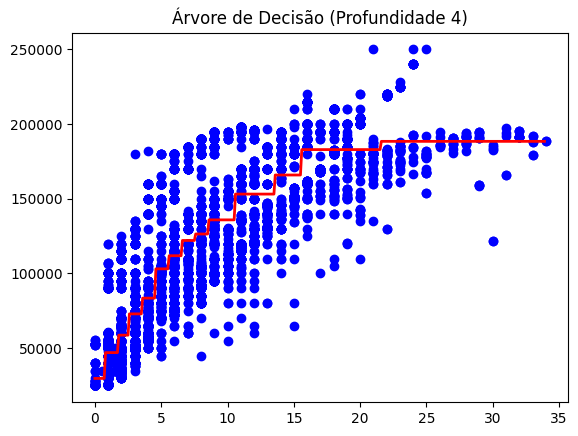

In [45]:
# Treinando
tree_reg = DecisionTreeRegressor(max_depth=4) # max_depth baixo evita overfitting (a curva "louca")
tree_reg.fit(dados[['Years of Experience']], dados['Salary'])

# Plotando
X_grid = np.arange(min(dados['Years of Experience']), max(dados['Years of Experience']), 0.1).reshape(-1, 1)
plt.scatter(dados['Years of Experience'], dados['Salary'], color='blue')
plt.plot(X_grid, tree_reg.predict(X_grid), color='red', linewidth=2)
plt.title("Árvore de Decisão (Profundidade 4)")
plt.show()


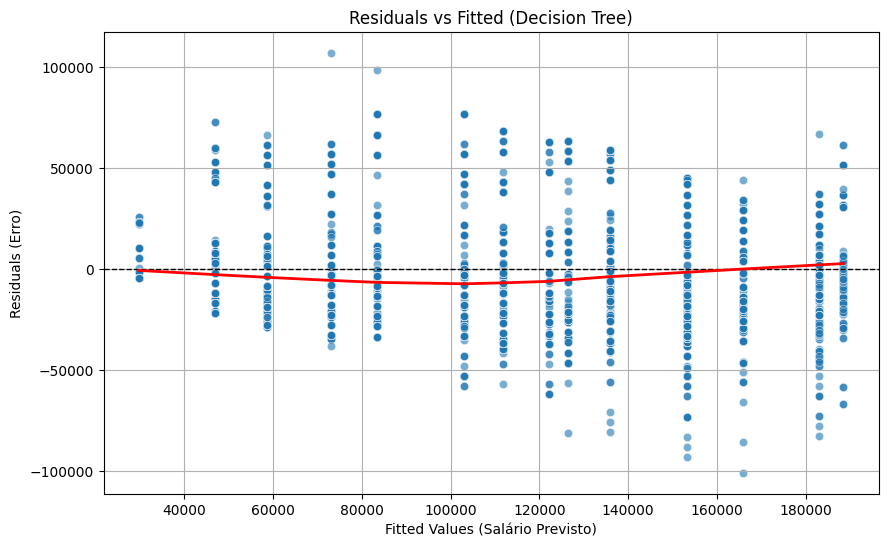

In [ ]:
# Gerando as previsões e resíduos da Árvore
y_pred_tree = tree_reg.predict(dados[['Years of Experience']])
residuals_tree = dados['Salary'] - y_pred_tree

# Plotando Residuals vs Fitted
plt.figure(figsize=(10, 6))

# Scatterplot dos resíduos
sns.scatterplot(x=y_pred_tree, y=residuals_tree, alpha=0.6)

# Linha de referência no zero
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Linha de tendência (LOWESS) em vermelho para ver o viés
sns.regplot(x=y_pred_tree, y=residuals_tree, scatter=False, ci=False, lowess=True,
            line_kws={'color': 'red', 'lw': 2})

plt.title("Residuals vs Fitted (Decision Tree)")
plt.xlabel("Fitted Values (Salário Previsto em Rupias)")
plt.ylabel("Residuals (Erro em Rupias)")
plt.grid(True)
plt.show()

Aqui podemos ver linhas verticais de pontos, isso é causado pelo fato da Árvore de Decisão prever valores discretos ("degraus"). Todo mundo que cai na mesma "folha" da árvore recebe exatamente a mesma previsão de salário.

Agora temos uma linha vermelha (viés) praticamente reto e colado na linha tracejada do zero, o que é ótimo. Ela ondula minimamente, o que é normal, mas não tem aquele "U" gigante ou curvas estranhas nas pontas.

Até então, foi o melhor modelo que conseguimos. Ele não tem viés sistemático (ele acerta a média de salário tanto para o estagiário quanto para o chefe).

Quanto à variância, os pontos estão bem distribuídos acima e abaixo do zero em quase todas as linhas verticais. Ela ainda é maior no meio/fim do que no começo, mas isso pode ser algo da natureza dos dados (salários altos variam mais), talvez nenhum modelo poderia "sumir" com isso a menos que façamos uma transformação logarítmica, mas a Árvore lida bem com isso sem distorcer a média.